# Development and Testing Notebook

In [ ]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

In [ ]:
import options_wizard as ow
from operator import ne, ge

uv = ow.Universe(['AAPL'])
pl = ow.Pipeline(universe=uv, saves=ow.SaveFrames.DATA)
kwargs = {
    'drop_val': ['c', 'ttm'],
    'drop_vol' : ['call_put', 120],
    'drop_symb': [ne, ge]
    }

In [ ]:
from functools import partial
from typing import List, Any
ow.wrap_fn = partial(ow.wrap_fn, pipeline=pl, kwargs=kwargs)

@ow.wrap_fn(ow.FuncType.LOAD)
def load_data(**kwargs) -> ow.DataType:
    """Loads in data for the tick"""
    
    # -- Imports --
    from dotenv import load_dotenv
    import os
    import polars as pl

    # -- Load Data --
    load_dotenv()
    tick = kwargs.get("tick", "")
    tick_path = os.getenv("TICK_PATH", "")
    data = pl.read_parquet(os.path.join(tick_path, f"{tick}.parquet"))

    return ow.DataType(data, tick)

@ow.wrap_fn(ow.FuncType.DATA, depends_on=[load_data])
def ttms(data: ow.DataType, **kwargs) -> ow.DataType:
    """Adds time to maturity column to data."""
    # -- Imports --
    import polars as pl
    from datetime import datetime

    # -- Calculate TTM --
    df = data().with_columns(
        (
            (pl.col("expiry_date").cast(pl.Date) - pl.col("trade_date").cast(pl.Date))
            .dt.total_days()
            / 365.0
        ).alias("ttm")
    )
    return ow.DataType(df, kwargs.get("tick", ""))

@ow.wrap_fn(ow.FuncType.DATA, depends_on=[load_data])
def filter(data: ow.DataType, **kwargs) -> ow.DataType:
    """Drops option type column from data."""
    # -- Imports --
    import polars as pl
    from typing import List, Any

    # -- Get Args --
    drop: str | List[Any] = kwargs.get("drop_val", "")
    col: str | List['str'] = kwargs.get("drop_vol", "")
    oper = kwargs.get("drop_oper", "")
    tick = kwargs.get("tick", "")

    # -- Drop Column --
    for d, c, o in zip(drop, col, oper):
        df = data().filter(oper(pl.col(c), d))
    return ow.DataType(df, tick)

@ow.wrap_fn(ow.FuncType.DATA, depends_on=[load_data])
def underlying_close(data: ow.DataType, **kwargs) -> ow.DataType:
    """Adds underlying close price to data."""
    # -- Imports --
    import yfinance as yf
    import polars as pl

    # -- Get Underlying Data --
    tick = kwargs.get("tick", "")
    ticker = yf.Ticker(tick)

    # -- Download History --
    df = data()
    start = df.select(pl.col("trade_date").min()).item()
    end = df.select(pl.col("trade_date").max()).item()
    hist = ticker.history(
        start=start.strftime("%Y-%m-%d"),
        end=end.strftime("%Y-%m-%d"),
        auto_adjust=False,
        interval="1d",
    ).reset_index()

    # -- Normalise date --
    hist["Date"] = hist["Date"].dt.tz_localize(None)

    # -- Merge Data --
    hist_pl = (
        pl.from_pandas(hist)
        .with_columns(
            pl.col("Date").dt.date().alias("trade_date")
        )
        .rename({"Close": "underlying_close"})
        .select(["trade_date", "underlying_close"])
    )

    merged_df = df.join(hist_pl, on="trade_date", how="left")

    return ow.DataType(merged_df, tick)


@ow.wrap_fn(ow.FuncType.DATA, depends_on=[load_data])
def scale_splits(data: ow.DataType, **kwargs) -> ow.DataType:
    """Scales data for stock splits using Polars expressions."""
    # -- Imports --
    import yfinance as yf
    import polars as pl

    # -- Get Splits --
    tick = kwargs.get("tick", "")
    ticker = yf.Ticker(tick)
    splits = ticker.splits

    # -- Edge handling --
    if splits.empty:
        return data

    # -- Process Splits --
    splits = (
        splits.reset_index()
        .rename(columns={"index": "Date", "Stock Splits": "Split"})
    )
    splits["Date"] = splits["Date"].dt.tz_localize(None)
    splits = splits.sort_values("Date")
    cols_to_reduce = ["last_trade_price", "bid_price", "ask_price", "strike"]
    cols_to_increase = ["volume", "open_interest"]

    # -- Apply Splits --
    df = data()
    for date, ratio in zip(splits["Date"], splits["Split"]):
        df = df.with_columns([
            pl.when(pl.col("trade_date") < date)
              .then(pl.col(col) / ratio)
              .otherwise(pl.col(col))
              .alias(col) for col in cols_to_reduce
        ] + [pl.when(pl.col("trade_date") < date)
              .then(pl.col(col) * ratio)
              .otherwise(pl.col(col))
              .alias(col) for col in cols_to_increase
        ])

    return ow.DataType(df, tick)




In [ ]:
pl.run()

ColumnNotFoundError: unable to find column "expiration_date"; valid columns: ["trade_date", "strike", "expiry_date", "call_put", "last_trade_price", "bid_price", "ask_price", "bid_implied_volatility", "ask_implied_volatility", "open_interest", "volume", "delta", "gamma", "vega", "theta", "rho", "year", "quarter", "ticker"]

: 

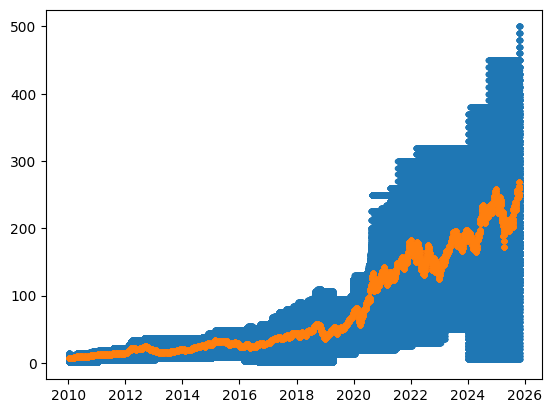

In [ ]:
import matplotlib.pyplot as plt
data=ow.DataType.load(tick="AAPL")
plt.plot(data()['trade_date'], data()['strike'], '.')
plt.plot(data()['trade_date'], data()['underlying_close'], '.')

In [ ]:
type(data())

polars.dataframe.frame.DataFrame